In [1]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import ascii
from astropy.table import Table

BANDS = ['g', 'r', 'i']
UPPER_LIMIT_MAGS = {
    'pstarr' : {'g': 23.3, 'r': 23.2, 'i': 23.1},
    'ztf': {'g': 23.3, 'r': 23.2, 'i': 23.1}
}

In [2]:
from typing import Optional

def img_ab_mag_to_flux(mag: np.ndarray, zero_point: np.ndarray, magerr: Optional[np.ndarray] = None) -> np.ndarray:
    """Inverse of img_flux_to_ab_mag."""
    flux = 10 ** ((mag - zero_point) / -2.5)
    if magerr is not None:
        fluxerr = (magerr * (np.log(10) * flux)) / 2.5
        return flux, fluxerr
    return flux

def get_snr_from_mag(mag, magerr, zp):
        flux, fluxerr = img_ab_mag_to_flux(mag, zero_point=zp, magerr=magerr)
        return flux / fluxerr

In [3]:
def catalog_filter(tab: Table, band: str, copy: bool = True) -> Table:
    # 0 — Both catalogs
    # 1 — ZTF, not Pan-STARRS, and not nan in either
    # 2 — Pan-STARRS, not ZTF, and not nan in either
    # 3 — Nan in either Pan-STARRS or ZTF
    if copy: tab = tab.copy()
    mask = np.isin(tab[f'Catalog_Flag'], [0, 1, 2])
    return tab[mask]

def psf_fit_filter(tab: Table, band: str, copy: bool = True) -> Table:
    # Flags here https://photutils.readthedocs.io/en/stable/api/photutils.psf.PSFPhotometry.html#photutils.psf.PSFPhotometry.__call__
    if copy: tab = tab.copy()
    okay_flags = [0, 4]
    mask = np.logical_or(np.isin(tab[f'ZTF_{band}PSFFlags'], okay_flags), tab['Catalog_Flag'] == 2)
    return tab[mask]

def sep_extraction_filter(tab: Table, band: str, copy: bool = True) -> Table:
    # flags here: https://sextractor.readthedocs.io/en/latest/Flagging.html
    if copy: tab = tab.copy()
    okay_flags = [0, 1, 2, 3]
    mask = np.logical_or(np.isin(tab[f'ZTF_sepExtractionFlag'], okay_flags), np.isin(tab['Catalog_Flag'], [2, 1]))
    return tab[mask]

def mag_diff_filter(tab: Table, band: str, copy: bool = True) -> Table:
    if copy: tab = tab.copy()
    pstarr_mag_diff = tab[f'PSTARR_{band}PSFMag'] - tab[f'PSTARR_{band}KronMag']
    ztf_mag_diff = tab[f'ZTF_{band}PSFMag'] - tab[f'ZTF_{band}KronMag']
    mask = np.logical_or((pstarr_mag_diff < 0.05), (ztf_mag_diff < 0.05))
    return tab[mask]

def snr_filter(tab: Table, band: str, snr_min: float = 5, copy: bool = True) -> Table:
    if copy: tab = tab.copy()

    # PSF
    pstarr_psf_snr = get_snr_from_mag(tab[f'PSTARR_{band}PSFMag'], tab[f'PSTARR_{band}PSFMagErr'], zp=25)
    ztf_psf_snr = get_snr_from_mag(tab[f'ZTF_{band}PSFMag'], tab[f'ZTF_{band}PSFMagErr'], zp=25)
    psf_mask = np.logical_or((pstarr_psf_snr > snr_min), (ztf_psf_snr > snr_min))

    # Kron
    ztf_kron_snr = get_snr_from_mag(tab[f'ZTF_{band}KronMag'], tab[f'ZTF_{band}KronMagErr'], zp=25)
    pstarr_kron_snr = get_snr_from_mag(tab[f'PSTARR_{band}KronMag'], tab[f'PSTARR_{band}KronMagErr'], zp=25)
    kron_mask = np.logical_or((pstarr_kron_snr > snr_min), (ztf_kron_snr > snr_min))

    # Total
    mask = np.logical_or(psf_mask, kron_mask)

    return tab[mask]

def preliminary_filter(original_tab: Table, band: str) -> Table:
    tab = original_tab.copy()
    for filt in [catalog_filter, psf_fit_filter, sep_extraction_filter, snr_filter]:
        tab = filt(tab, band=band, copy=False)
        print(f'{filt.__name__} filtered out {len(original_tab) - len(tab)} / {len(original_tab)} = {(len(original_tab) - len(tab)) / len(original_tab):.4f} sources from {band} band.')
    return tab

# Look at one field (000513)

In [4]:
g_tab = ascii.read('/Users/adamboesky/Research/long_transients/Data/catalog_results/field_results/000513_g.ecsv')
r_tab = ascii.read('/Users/adamboesky/Research/long_transients/Data/catalog_results/field_results/000513_r.ecsv')
i_tab = ascii.read('/Users/adamboesky/Research/long_transients/Data/catalog_results/field_results/000513_i.ecsv')
tables = {'g': g_tab, 'r': r_tab, 'i': i_tab}

# Set values <=0 to the upper limit for ZTF
for band in BANDS:
    tab = tables[band]
    upper_lim_mask = tab[f'ZTF_{band}PSFFlags'] == 4
    tab[f'ZTF_{band}PSFMag'][upper_lim_mask] = UPPER_LIMIT_MAGS['ztf'][band]   # 4 means flux was negative
    tab[f'ZTF_{band}_upper_lim'] = False
    tab[f'ZTF_{band}_upper_lim'][upper_lim_mask] = True
    tables[band] = tab

print(len(g_tab), len(r_tab), len(i_tab))
g_tab

369234 371944 374602


ra,dec,ZTF_thresh,ZTF_npix,ZTF_tnpix,ZTF_xmin,ZTF_xmax,ZTF_ymin,ZTF_ymax,ZTF_x,ZTF_y,ZTF_x2,ZTF_y2,ZTF_xy,ZTF_errx2,ZTF_erry2,ZTF_errxy,ZTF_a,ZTF_b,ZTF_theta,ZTF_cxx,ZTF_cyy,ZTF_cxy,ZTF_cflux,ZTF_flux,ZTF_cpeak,ZTF_peak,ZTF_xcpeak,ZTF_ycpeak,ZTF_xpeak,ZTF_ypeak,ZTF_sepExtractionFlag,ZTF_KronRad,ZTF_gKronMag,ZTF_gKronMagErr,ZTF_gKronCircleFlag,ZTF_gKronFlag,ZTF_gPSFMag,ZTF_gPSFMagErr,ZTF_gPSFFlags,ZTF_qfit,ZTF_cfit,ZTF_g_zero_pt_mag,ZTF_ra,ZTF_dec,PSTARR_PanSTARR_ID,PSTARR_gKronMag,PSTARR_rKronMag,PSTARR_iKronMag,PSTARR_gKronMagErr,PSTARR_rKronMagErr,PSTARR_iKronMagErr,PSTARR_gApMag,PSTARR_rApMag,PSTARR_iApMag,PSTARR_gApMagErr,PSTARR_rApMagErr,PSTARR_iApMagErr,PSTARR_gPSFMag,PSTARR_rPSFMag,PSTARR_iPSFMag,PSTARR_gPSFMagErr,PSTARR_rPSFMagErr,PSTARR_iPSFMagErr,PSTARR_gpsfLikelihood,PSTARR_rpsfLikelihood,PSTARR_ipsfLikelihood,PSTARR_primaryDetection,PSTARR_ra,PSTARR_dec,association_separation_arcsec,Catalog,Catalog_Flag,x,y,ZTF_g_upper_lim
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str6,int64,float64,float64,bool
97.08175280337181,13.558841024788052,0.9307897686958313,7.0,2.0,1065.0,1067.0,70.0,72.0,1066.3559775866665,71.0,0.398724315366793,0.4576333072726959,0.0,0.021604533433052076,0.02495334165844643,0.0,0.6764860153198242,0.6314461827278137,-1.5707962830835065,2.507998466491699,2.1851556301116943,-0.0,11.800485610961914,14.400787353515625,2.7999935150146484,7.9991607666015625,1066.0,71.0,1066.0,71.0,0.0,0.0,21.262479153796917,0.08328673831564218,1.0,160.0,nan,nan,nan,nan,nan,26.325,97.08174826656185,13.558720001913905,1.2427097081757125e+17,21.7108001708984,20.0816993713379,18.9260005950928,0.0742729976773262,0.0174209997057915,0.0113340001553297,21.7171001434326,20.0067005157471,18.82080078125,0.00771200004965067,0.00310100009664893,0.00224600010551512,21.3598003387451,19.878999710083,19.1287002563477,0.0427640005946159,0.0105050001293421,0.00946800038218498,-9.97528986772522e-05,-0.043545700609684,6.95182977850095e-09,1.0,97.0817573401818,13.5589620476622,0.8719431101204704,Both,0,1066.3559775866665,71.0,False
97.0487448669643,13.558118691302987,0.9307897686958313,15.0,4.0,948.0,952.0,70.0,74.0,950.6351788865919,71.44641168581812,0.897290395764478,1.0172671059153875,-0.3884149625602573,0.005354179502357401,0.005811123585511472,-0.0022052197294451497,1.1620235443115234,0.7511715292930603,-0.8620148301124573,1.3351402282714844,1.1776734590530396,1.0195717811584473,57.64036560058594,61.881317138671875,10.448360443115234,41.79344177246094,951.0,71.0,951.0,71.0,0.0,1.3073444062292299,19.01076031163206,0.010704018915481015,1.0,32.0,nan,nan,nan,nan,nan,26.325,97.0486883236413,13.558144376375774,1.2427097048803019e+17,20.0988998413086,19.3512992858887,18.7915000915527,0.0184969995170832,0.010584999807179,0.0079950001090765,19.9953994750977,19.2605991363525,18.6604995727539,0.00349000003188849,0.00219899998046458,0.0020860000513494,20.0611000061035,19.2215995788574,18.7252006530762,0.0145319998264313,0.00755099998787045,0.00615700008347631,0.00473017990589142,0.0531213991343975,0.20066399872303,1.0,97.0488014102873,13.5580930062302,0.43684251796138335,Both,0,950.6351788865919,71.44641168581812,False
97.39974898203306,13.562550638574045,0.9307897686958313,22.0,6.0,2174.0,2181.0,71.0,74.0,2179.004410075288,72.04676997572884,2.3675129777660295,0.5548606233231299,-0.18447569892698645,0.006007936383215096,0.0009517122141362933,-0.0009572120488852654,1.5446995496749878,0.7323092818260193,-0.10039963573217392,0.433617502450943

In [5]:
filtered_tables = {band: preliminary_filter(tab, band=band) for band, tab in tables.items()}

catalog_filter filtered out 0 / 369234 = 0.0000 sources from g band.
psf_fit_filter filtered out 2865 / 369234 = 0.0078 sources from g band.
sep_extraction_filter filtered out 2873 / 369234 = 0.0078 sources from g band.


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_20026/2294796586.py:5: RuntimeWarning: overflow encountered in power
  flux = 10 ** ((mag - zero_point) / -2.5)
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_20026/2294796586.py:13: RuntimeWarning: invalid value encountered in divide
  return flux / fluxerr


snr_filter filtered out 190858 / 369234 = 0.5169 sources from g band.
catalog_filter filtered out 0 / 371944 = 0.0000 sources from r band.
psf_fit_filter filtered out 3816 / 371944 = 0.0103 sources from r band.
sep_extraction_filter filtered out 3833 / 371944 = 0.0103 sources from r band.
snr_filter filtered out 137459 / 371944 = 0.3696 sources from r band.
catalog_filter filtered out 0 / 374602 = 0.0000 sources from i band.
psf_fit_filter filtered out 4853 / 374602 = 0.0130 sources from i band.
sep_extraction_filter filtered out 4874 / 374602 = 0.0130 sources from i band.
snr_filter filtered out 62442 / 374602 = 0.1667 sources from i band.


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_20026/2294796586.py:5: RuntimeWarning: overflow encountered in power
  flux = 10 ** ((mag - zero_point) / -2.5)
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_20026/2294796586.py:13: RuntimeWarning: invalid value encountered in divide
  return flux / fluxerr


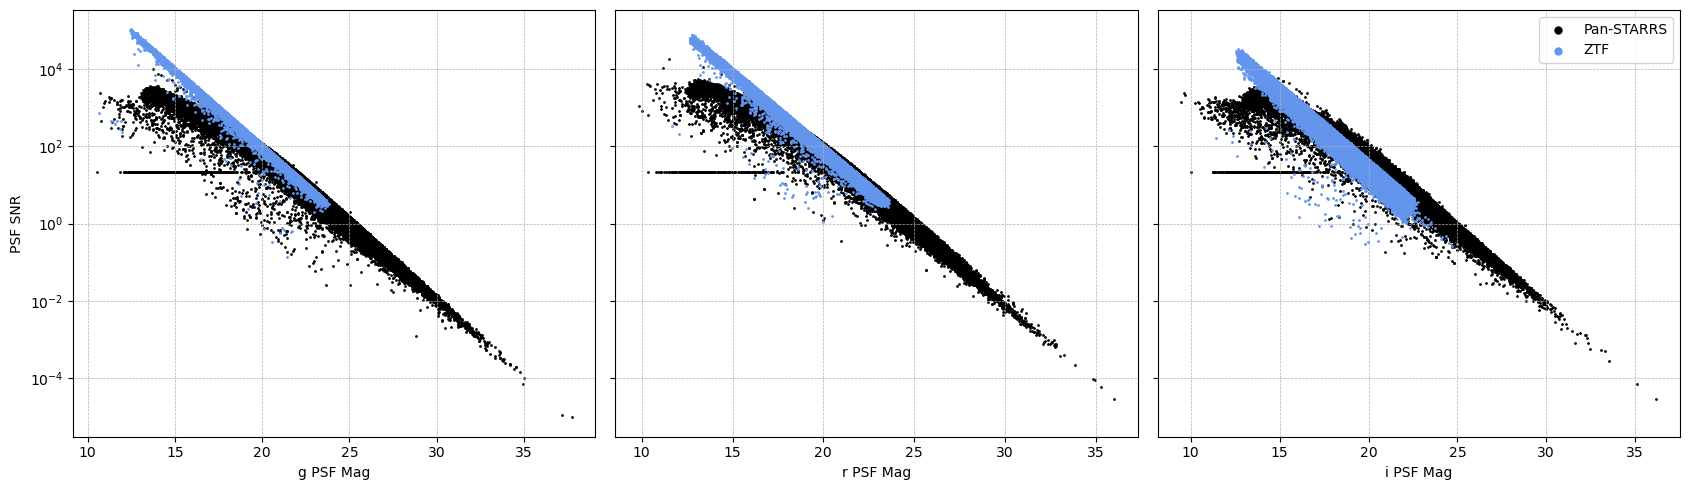

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(17, 5), sharey=True)

for ax, band in zip(axes.flatten(), BANDS):

    # Get the band's table 
    tab = tables[band]

    # Calculate SNRs
    pstarr_snr = get_snr_from_mag(tab[f'PSTARR_{band}PSFMag'], tab[f'PSTARR_{band}PSFMagErr'], zp=25)  #TODO: Check zero points
    ztf_snr = get_snr_from_mag(tab[f'ZTF_{band}PSFMag'], tab[f'ZTF_{band}PSFMagErr'], zp=tab[f'ZTF_{band}_zero_pt_mag'])

    # Plot
    ax.scatter(tab[f'PSTARR_{band}PSFMag'], pstarr_snr, color='k', label='Pan-STARRS', s=1)
    ax.scatter(tab[f'ZTF_{band}PSFMag'], ztf_snr, color='cornflowerblue', label='ZTF', s=1)

    # Formatting
    ax.set_yscale('log')
    ax.grid(lw=0.5, ls='--')
    ax.set_xlabel(f'{band} PSF Mag')

axes[0].set_ylabel(f'PSF SNR')
axes[-1].legend(markerscale=5)
plt.tight_layout()
plt.show()

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_20026/2294796586.py:5: RuntimeWarning: overflow encountered in power
  flux = 10 ** ((mag - zero_point) / -2.5)
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_20026/2294796586.py:13: RuntimeWarning: invalid value encountered in divide
  return flux / fluxerr
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_20026/4245767528.py:43: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


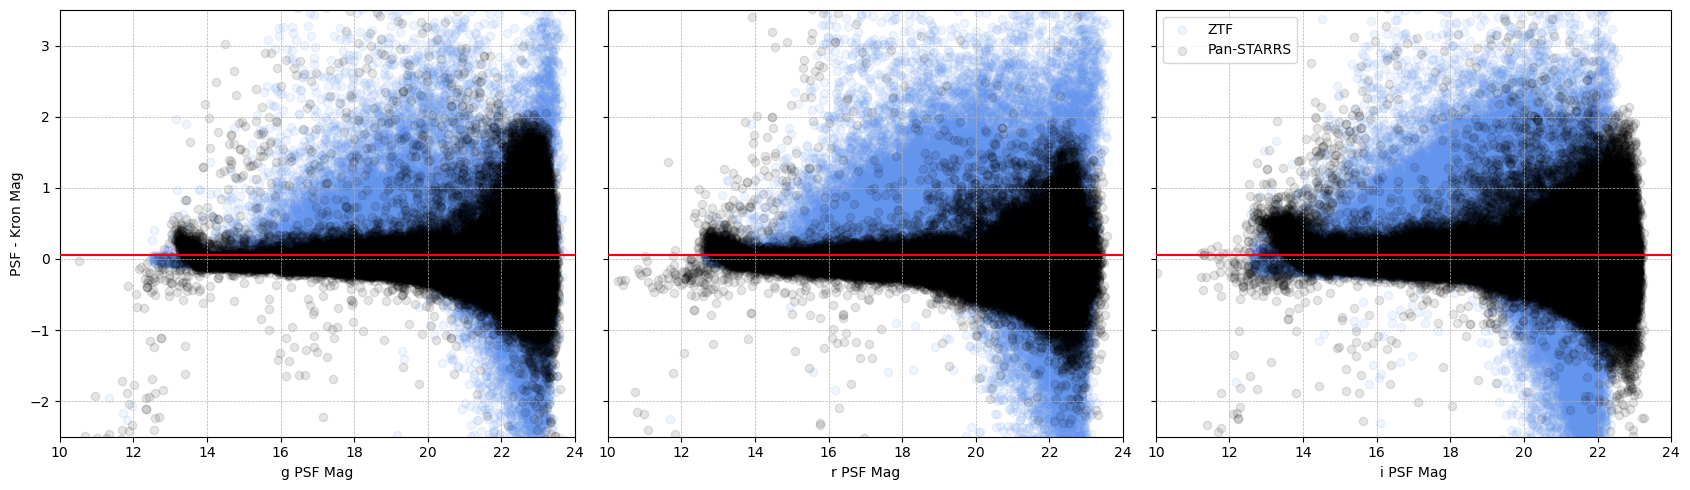

In [53]:
fig, axes = plt.subplots(1, 3, figsize=(17, 5), sharey=True)

for ax, band in zip(axes.flatten(), BANDS):

    # Get the band's table 
    tab = filtered_tables[band]

    # Calculate SNRs
    pstarr_snr = get_snr_from_mag(tab[f'PSTARR_{band}PSFMag'], tab[f'PSTARR_{band}PSFMagErr'], zp=25)  #TODO: Check zero points
    ztf_snr = get_snr_from_mag(tab[f'ZTF_{band}PSFMag'], tab[f'ZTF_{band}PSFMagErr'], zp=tab[f'ZTF_{band}_zero_pt_mag'])

    ##### BOTH #####
    # Masks
    pstarr_mask = pstarr_snr > 2
    ztf_mask = ztf_snr > 2

    # Plot
    # Without upper lims
    ax.scatter(
        tab[ztf_mask][f'ZTF_{band}PSFMag'],
        tab[ztf_mask][f'ZTF_{band}PSFMag'] - tab[ztf_mask][f'ZTF_{band}KronMag'],
        color='cornflowerblue',
        label='ZTF',
        alpha=0.1
    )
    ax.scatter(
        tab[pstarr_mask][f'PSTARR_{band}PSFMag'],
        tab[pstarr_mask][f'PSTARR_{band}PSFMag'] - tab[pstarr_mask][f'PSTARR_{band}KronMag'],
        color='k',
        label='Pan-STARRS',
        alpha=0.1
    )

    # Formatting
    ax.axhline(0.05, color='red', zorder=10)
    ax.grid(lw=0.5, ls='--')
    ax.set_xlabel(f'{band} PSF Mag')
    ax.set_ylim((-2.5, 3.5))
    ax.set_xlim((10, 24))

axes[0].set_ylabel(f'PSF - Kron Mag')
axes[-1].legend(markerscale=1)
plt.tight_layout()
plt.show()

In [15]:
tab = tables['g'].copy()
pstarr_snr = get_snr_from_mag(tab[f'PSTARR_gPSFMag'], tab[f'PSTARR_gPSFMagErr'], zp=25)
ztf_snr = get_snr_from_mag(tab[f'ZTF_gPSFMag'], tab[f'ZTF_gPSFMagErr'], zp=25)
mask = (pstarr_snr > 6) | (ztf_snr > 6)
tab = tab[mask]

with open('/Users/adamboesky/Desktop/ZTF_unassociated.txt', 'w') as f:
    for x, y in zip(tab[(tab['Catalog_Flag'] == 1)]['x'], tab[(tab['Catalog_Flag'] == 1)]['y']):
        f.write(f"{x} {y}\n")

with open('/Users/adamboesky/Desktop/PSTARR_unassociated.txt', 'w') as f:
    for x, y in zip(tab[(tab['Catalog_Flag'] == 2)]['x'], tab[(tab['Catalog_Flag'] == 2)]['y']):
        f.write(f"{x} {y}\n")

with open('/Users/adamboesky/Desktop/associated.txt', 'w') as f:
    for x, y in zip(tab[(tab['Catalog_Flag'] == 0)]['x'], tab[(tab['Catalog_Flag'] == 0)]['y']):
        f.write(f"{x} {y}\n")

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_76181/2294796586.py:5: RuntimeWarning: overflow encountered in power
  flux = 10 ** ((mag - zero_point) / -2.5)
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_76181/2294796586.py:13: RuntimeWarning: invalid value encountered in divide
  return flux / fluxerr


In [16]:
# from Extracting.Catalogs import ZTF_Catalog

# test = ZTF_Catalog(tables['g']['ra'][0], tables['g']['dec'][0], data_dir='/Users/adamboesky/Research/long_transients/Data/ztf_data')
# test.sextractors['g'].fits_fpath

Table size: 178376


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_20026/2294796586.py:5: RuntimeWarning: overflow encountered in power
  flux = 10 ** ((mag - zero_point) / -2.5)
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_20026/2294796586.py:13: RuntimeWarning: invalid value encountered in divide
  return flux / fluxerr


Table size: 234485
Table size: 312160


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_20026/2719202692.py:92: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[-1].legend(markerscale=5)


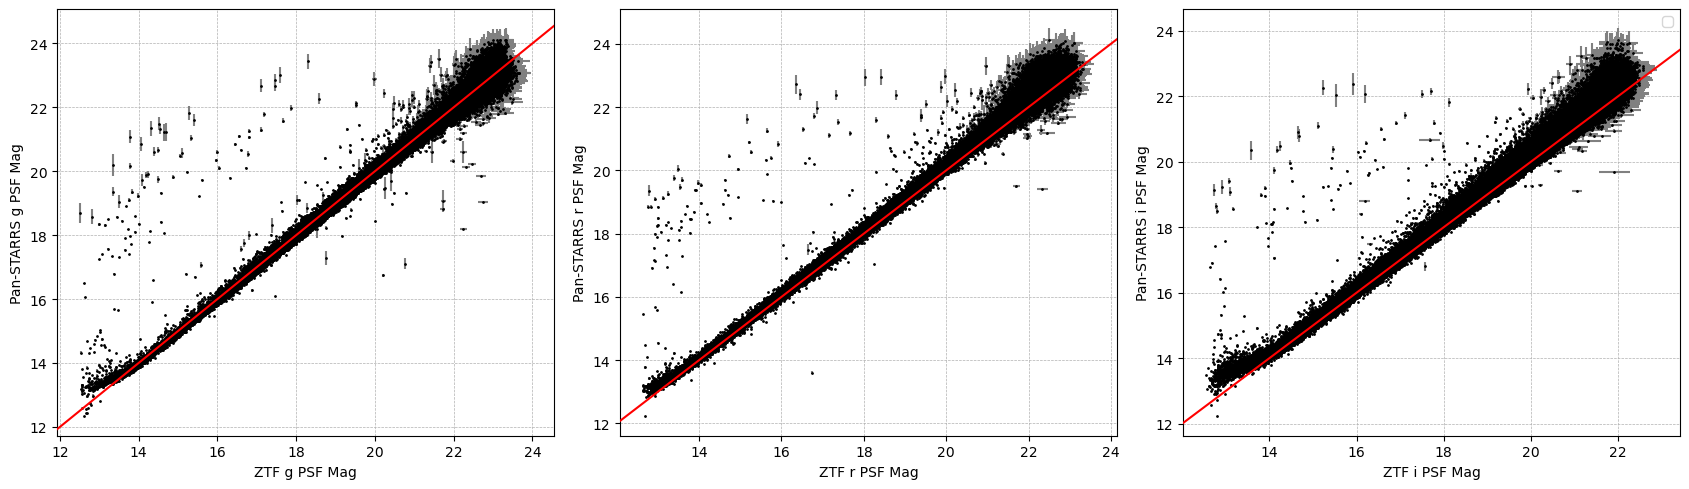

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(17, 5))

for ax, band in zip(axes.flatten(), BANDS):

    # Get the band's table 
    tab = filtered_tables[band]
    print(f'Table size: {len(tab)}')

    # Calculate SNRs
    pstarr_snr = get_snr_from_mag(tab[f'PSTARR_{band}PSFMag'], tab[f'PSTARR_{band}PSFMagErr'], zp=25)  #TODO: Check zero points
    ztf_snr = get_snr_from_mag(tab[f'ZTF_{band}PSFMag'], tab[f'ZTF_{band}PSFMagErr'], zp=tab[f'ZTF_{band}_zero_pt_mag'])

    ##### BOTH #####
    # Masks
    both_mask = (tab['Catalog'] == 'Both') & (tab[f'PSTARR_{band}PSFMag'] != -999) & (tab[f'ZTF_{band}PSFFlags'] == 0)
    ztf_upper_lim_mask = tab[f'ZTF_{band}_upper_lim']

    # Plot
    # Without upper lims
    mask = both_mask & (pstarr_snr > 3) & (ztf_snr > 3) & ~ztf_upper_lim_mask
    ax.errorbar(
        tab[mask][f'ZTF_{band}PSFMag'],
        tab[mask][f'PSTARR_{band}PSFMag'],
        xerr=tab[mask][f'ZTF_{band}PSFMagErr'],
        yerr=tab[mask][f'PSTARR_{band}PSFMagErr'],
        color='k',
        linestyle="None",
        fmt="o",
        markersize=1,
        ecolor='gray',
    )
    # # Just upper lims
    # mask = both_mask & (pstarr_snr > 3) & ztf_upper_lim_mask
    # print(f'Plotting {np.sum(mask)} / {np.sum(ztf_upper_lim_mask)} upper limits')
    # ax.errorbar(
    #     tab[mask][f'ZTF_{band}PSFMag'],
    #     tab[mask][f'PSTARR_{band}PSFMag'],
    #     xerr=[0.25 for _ in range(np.sum(mask))],
    #     yerr=tab[mask][f'PSTARR_{band}PSFMagErr'],
    #     xuplims=True,
    #     color='k',
    #     linestyle="None",
    #     fmt="o",
    #     markersize=1,
    #     ecolor='gray',
    # )

    # ##### Only in PSTARR #####
    # # Mask
    # pstarr_mask = (tab['Catalog'] == 'PSTARR') & (tab[f'PSTARR_{band}PSFMag'] != -999) & (tab[f'PSTARR_{band}PSFMagErr'] != -999)
    # mask = pstarr_mask & (pstarr_snr > 3)

    # # Plot
    # upper_lims = [UPPER_LIMIT_MAGS['ztf'][band] for _ in range(np.sum(mask))]
    # ax.errorbar(
    #     upper_lims,
    #     tab[mask][f'PSTARR_{band}PSFMag'],
    #     xerr=[0.25 for _ in range(len(upper_lims))],
    #     yerr=tab[mask][f'PSTARR_{band}PSFMagErr'],
    #     xuplims=True,
    #     color='blue',
    #     linestyle="None",
    #     fmt="o",
    #     markersize=1,
    # )

    # ##### Only in ZTF #####
    # # Mask
    # ztf_mask = (tab['Catalog'] == 'ZTF')
    # mask = ztf_mask & (ztf_snr > 3)

    # # Plot
    # upper_lims = [UPPER_LIMIT_MAGS['pstarr'][band] for _ in range(np.sum(mask))]
    # ax.errorbar(
    #     tab[mask][f'ZTF_{band}PSFMag'],
    #     upper_lims,
    #     yerr=[0.25 for _ in range(len(upper_lims))],
    #     xerr=tab[mask][f'ZTF_{band}PSFMagErr'],
    #     uplims=True,
    #     color='forestgreen',
    #     linestyle="None",
    #     fmt="o",
    #     markersize=1,
    # )

    # Formatting
    ax.axline((15, 15), slope=1, color='red', zorder=10)
    ax.grid(lw=0.5, ls='--')
    ax.set_ylabel(f'Pan-STARRS {band} PSF Mag')
    ax.set_xlabel(f'ZTF {band} PSF Mag')

axes[-1].legend(markerscale=5)
plt.tight_layout()
plt.show()

In [81]:
ztf_snr = get_snr_from_mag(g_tab['ZTF_gPSFMag'], g_tab['ZTF_gPSFMagErr'], zp=25)
pstarr_snr = get_snr_from_mag(g_tab['PSTARR_gPSFMag'], g_tab['PSTARR_gPSFMagErr'], zp=25)
pd.value_counts(g_tab['Catalog_Flag'], normalize=True)

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_20026/2996633302.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(g_tab['Catalog_Flag'], normalize=True)


Catalog_Flag
2    0.686608
0    0.300362
1    0.013030
Name: proportion, dtype: float64

Table size: 178376


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_20026/2294796586.py:5: RuntimeWarning: overflow encountered in power
  flux = 10 ** ((mag - zero_point) / -2.5)
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_20026/2294796586.py:13: RuntimeWarning: invalid value encountered in divide
  return flux / fluxerr


Table size: 234485
Table size: 312160


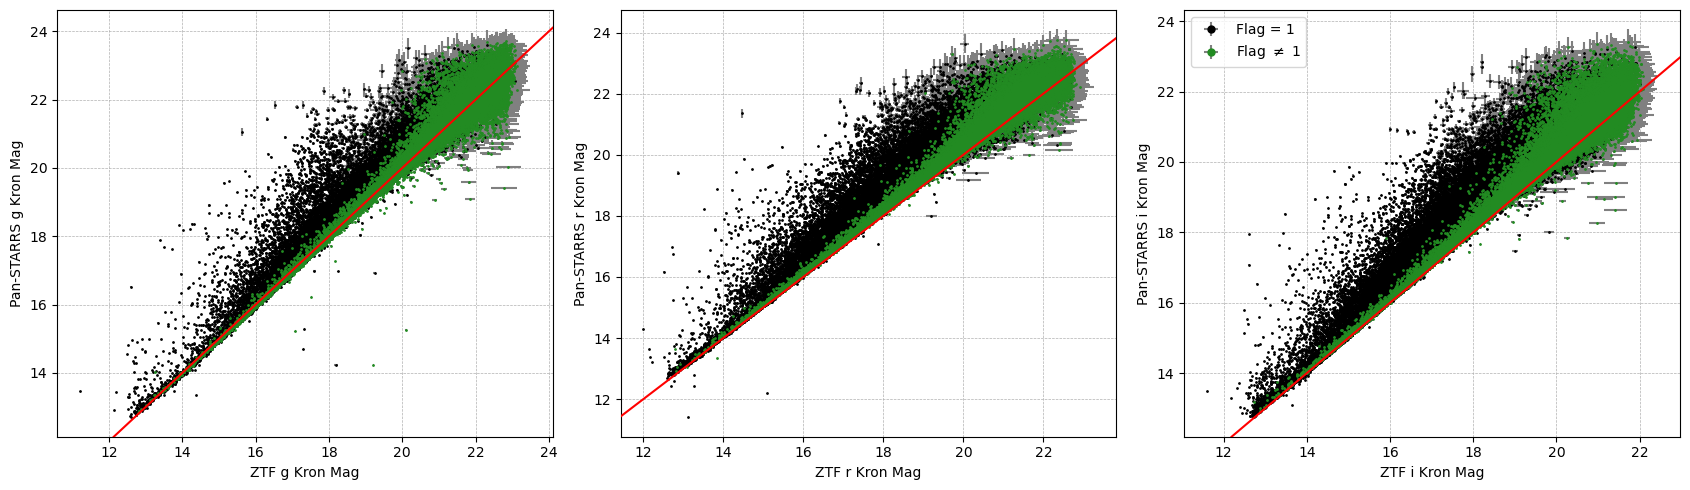

In [64]:
fig, axes = plt.subplots(1, 3, figsize=(17, 5))

for ax, band in zip(axes.flatten(), BANDS):

    # Get the band's table
    tab = filtered_tables[band]
    print(f'Table size: {len(tab)}')

    tab_1s = tab[tab['ZTF_sepExtractionFlag'] == 1]
    tab_not_1s = tab[tab['ZTF_sepExtractionFlag'] != 1]
    
    for tab, col, lab in zip([tab_1s, tab_not_1s], ['k', 'forestgreen'], ['Flag = 1', r'Flag $\neq$ 1']):

        # Calculate SNRs
        pstarr_snr = get_snr_from_mag(tab[f'PSTARR_{band}KronMag'], tab[f'PSTARR_{band}KronMagErr'], zp=25)  #TODO: Check zero points
        ztf_snr = get_snr_from_mag(tab[f'ZTF_{band}KronMag'], tab[f'ZTF_{band}KronMagErr'], zp=tab[f'ZTF_{band}_zero_pt_mag'])

        ##### BOTH #####
        # Masks
        both_mask = (tab['Catalog'] == 'Both') & (tab[f'PSTARR_{band}KronMag'] != -999)
        ztf_upper_lim_mask = tab[f'ZTF_{band}_upper_lim']

        # Plot
        # Without upper lims
        mask = both_mask & (pstarr_snr > 3) & (ztf_snr > 3) & ~ztf_upper_lim_mask
        ax.errorbar(
            tab[mask][f'ZTF_{band}KronMag'],
            tab[mask][f'PSTARR_{band}KronMag'],
            xerr=tab[mask][f'ZTF_{band}KronMagErr'],
            yerr=tab[mask][f'PSTARR_{band}KronMagErr'],
            color=col,
            linestyle="None",
            fmt="o",
            markersize=1,
            ecolor='gray',
            label=lab,
        )
        # # Just upper lims
        # mask = both_mask & (pstarr_snr > 3) & ztf_upper_lim_mask
        # print(f'Plotting {np.sum(mask)} / {np.sum(ztf_upper_lim_mask)} upper limits')
        # ax.errorbar(
        #     tab[mask][f'ZTF_{band}PSFMag'],
        #     tab[mask][f'PSTARR_{band}PSFMag'],
        #     xerr=[0.25 for _ in range(np.sum(mask))],
        #     yerr=tab[mask][f'PSTARR_{band}PSFMagErr'],
        #     xuplims=True,
        #     color='k',
        #     linestyle="None",
        #     fmt="o",
        #     markersize=1,
        #     ecolor='gray',
        # )

        # ##### Only in PSTARR #####
        # # Mask
        # pstarr_mask = (tab['Catalog'] == 'PSTARR') & (tab[f'PSTARR_{band}PSFMag'] != -999) & (tab[f'PSTARR_{band}PSFMagErr'] != -999)
        # mask = pstarr_mask & (pstarr_snr > 3)

        # # Plot
        # upper_lims = [UPPER_LIMIT_MAGS['ztf'][band] for _ in range(np.sum(mask))]
        # ax.errorbar(
        #     upper_lims,
        #     tab[mask][f'PSTARR_{band}PSFMag'],
        #     xerr=[0.25 for _ in range(len(upper_lims))],
        #     yerr=tab[mask][f'PSTARR_{band}PSFMagErr'],
        #     xuplims=True,
        #     color='blue',
        #     linestyle="None",
        #     fmt="o",
        #     markersize=1,
        # )

        # ##### Only in ZTF #####
        # # Mask
        # ztf_mask = (tab['Catalog'] == 'ZTF')
        # mask = ztf_mask & (ztf_snr > 3)

        # # Plot
        # upper_lims = [UPPER_LIMIT_MAGS['pstarr'][band] for _ in range(np.sum(mask))]
        # ax.errorbar(
        #     tab[mask][f'ZTF_{band}PSFMag'],
        #     upper_lims,
        #     yerr=[0.25 for _ in range(len(upper_lims))],
        #     xerr=tab[mask][f'ZTF_{band}PSFMagErr'],
        #     uplims=True,
        #     color='forestgreen',
        #     linestyle="None",
        #     fmt="o",
        #     markersize=1,
        # )

    # Formatting
    ax.axline((15, 15), slope=1, color='red', zorder=10)
    ax.grid(lw=0.5, ls='--')
    ax.set_ylabel(f'Pan-STARRS {band} Kron Mag')
    ax.set_xlabel(f'ZTF {band} Kron Mag')

axes[-1].legend(markerscale=5)
plt.tight_layout()
plt.show()

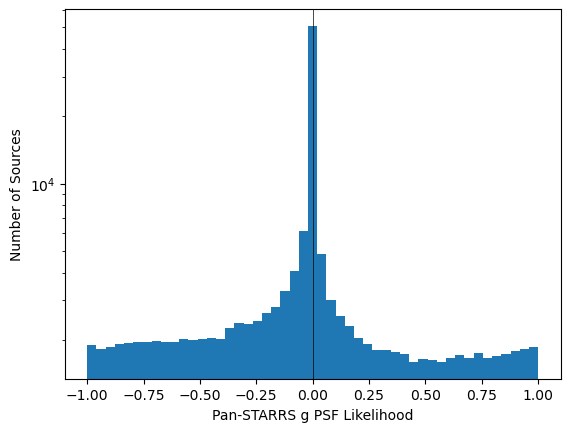

In [77]:
plt.hist(g_tab['PSTARR_gpsfLikelihood'][g_tab['PSTARR_gpsfLikelihood'] > -100], bins=np.linspace(-1, 1, 50))
plt.xlabel('Pan-STARRS g PSF Likelihood')
plt.ylabel('Number of Sources')
plt.yscale('log')
plt.axvline(0, color='k', lw=0.5)
plt.show()
# "This is around 0 for galaxies but can be either +1 or - 1 for stars"

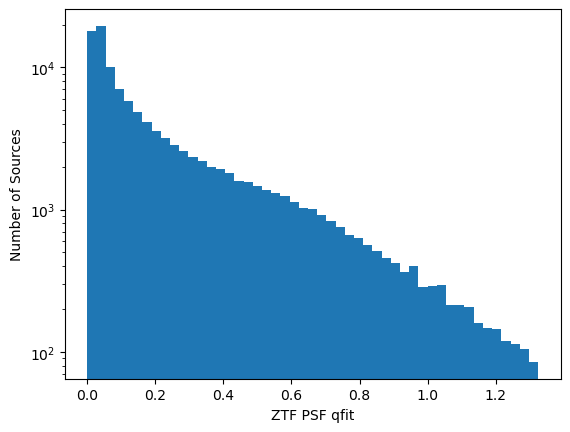

In [78]:
qfit_4sig_high = np.nanmean(g_tab['ZTF_qfit']) + 4 * np.nanstd(g_tab['ZTF_qfit'])
plt.hist(g_tab['ZTF_qfit'], bins=np.linspace(0, qfit_4sig_high, num=50))
plt.xlabel('ZTF PSF qfit')
plt.ylabel('Number of Sources')
plt.yscale('log')
plt.show()

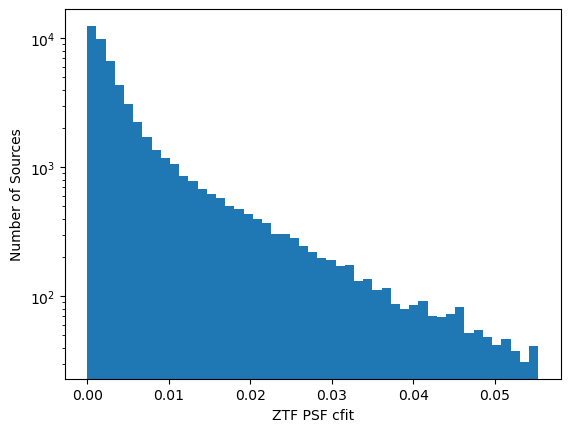

In [79]:
cfit_4sig_high = np.nanmean(g_tab['ZTF_cfit']) + 4 * np.nanstd(g_tab['ZTF_cfit'])
plt.hist(g_tab['ZTF_cfit'], bins=np.linspace(0, cfit_4sig_high, num=50))
plt.xlabel('ZTF PSF cfit')
plt.ylabel('Number of Sources')
plt.yscale('log')
plt.show()

Table size: 180512


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_76181/2294796586.py:5: RuntimeWarning: overflow encountered in power
  flux = 10 ** ((mag - zero_point) / -2.5)
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_76181/2294796586.py:13: RuntimeWarning: invalid value encountered in divide
  return flux / fluxerr


Table size: 237097
Table size: 315510


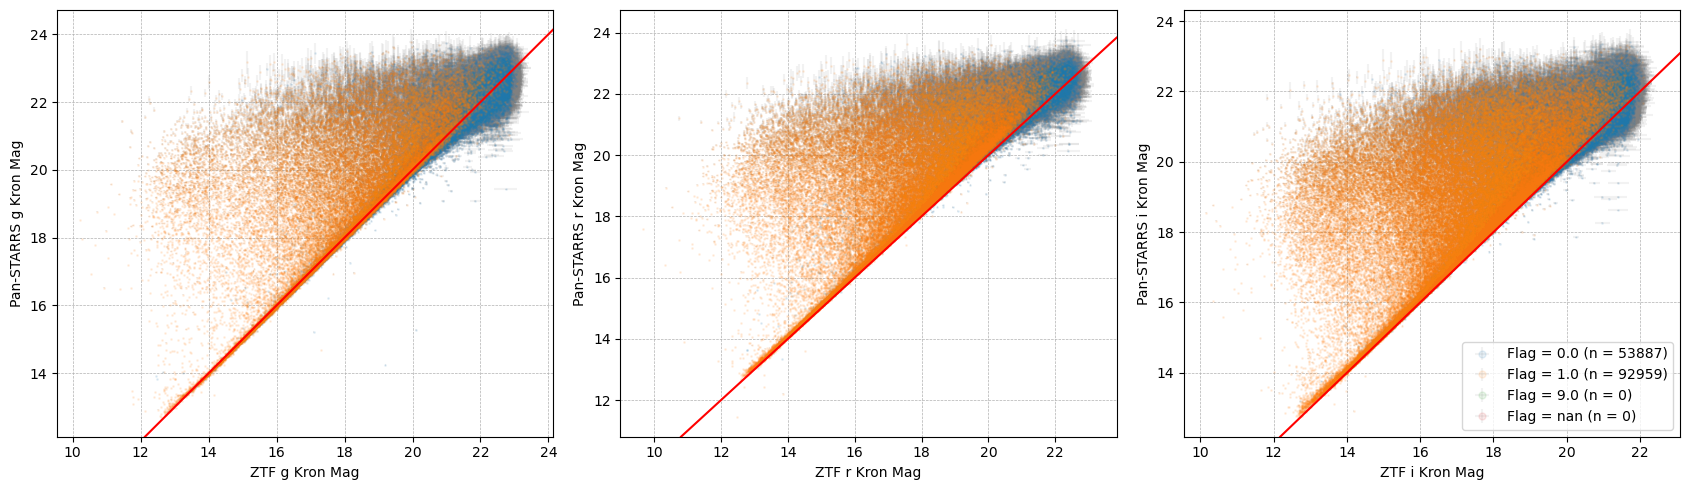

In [64]:
fig, axes = plt.subplots(1, 3, figsize=(17, 5))

for ax, band in zip(axes.flatten(), BANDS):

    # Get the band's table 
    tab = filtered_tables[band]
    print(f'Table size: {len(tab)}')

    # Calculate SNRs
    pstarr_snr = get_snr_from_mag(tab[f'PSTARR_{band}KronMag'], tab[f'PSTARR_{band}KronMagErr'], zp=25)  #TODO: Check zero points
    ztf_snr = get_snr_from_mag(tab[f'ZTF_{band}KronMag'], tab[f'ZTF_{band}KronMagErr'], zp=tab[f'ZTF_{band}_zero_pt_mag'])

    ##### BOTH #####
    # Masks
    both_mask = (tab['Catalog'] == 'Both') & (tab[f'PSTARR_{band}KronMag'] != -999)
    ztf_upper_lim_mask = tab[f'ZTF_{band}_upper_lim']

    # Plot
    # Without upper lims
    for f in np.unique(tab['ZTF_sepExtractionFlag']):
        mask = both_mask & (pstarr_snr > 3) & (ztf_snr > 3) & ~ztf_upper_lim_mask & (tab['ZTF_sepExtractionFlag'] == f)
        ax.errorbar(
            tab[mask][f'ZTF_{band}KronMag'],
            tab[mask][f'PSTARR_{band}KronMag'],
            xerr=tab[mask][f'ZTF_{band}KronMagErr'],
            yerr=tab[mask][f'PSTARR_{band}KronMagErr'],
            linestyle="None",
            fmt="o",
            markersize=1,
            ecolor='gray',
            label=f'Flag = {f} (n = {np.sum(mask)})',
            alpha=0.1
        )
        # # Just upper lims
        # mask = both_mask & (pstarr_snr > 3) & ztf_upper_lim_mask
        # print(f'Plotting {np.sum(mask)} / {np.sum(ztf_upper_lim_mask)} upper limits')
        # ax.errorbar(
        #     tab[mask][f'ZTF_{band}PSFMag'],
        #     tab[mask][f'PSTARR_{band}PSFMag'],
        #     xerr=[0.25 for _ in range(np.sum(mask))],
        #     yerr=tab[mask][f'PSTARR_{band}PSFMagErr'],
        #     xuplims=True,
        #     color='k',
        #     linestyle="None",
        #     fmt="o",
        #     markersize=1,
        #     ecolor='gray',
        # )

        # ##### Only in PSTARR #####
        # # Mask
        # pstarr_mask = (tab['Catalog'] == 'PSTARR') & (tab[f'PSTARR_{band}PSFMag'] != -999) & (tab[f'PSTARR_{band}PSFMagErr'] != -999)
        # mask = pstarr_mask & (pstarr_snr > 3)

        # # Plot
        # upper_lims = [UPPER_LIMIT_MAGS['ztf'][band] for _ in range(np.sum(mask))]
        # ax.errorbar(
        #     upper_lims,
        #     tab[mask][f'PSTARR_{band}PSFMag'],
        #     xerr=[0.25 for _ in range(len(upper_lims))],
        #     yerr=tab[mask][f'PSTARR_{band}PSFMagErr'],
        #     xuplims=True,
        #     color='blue',
        #     linestyle="None",
        #     fmt="o",
        #     markersize=1,
        # )

        # ##### Only in ZTF #####
        # # Mask
        # ztf_mask = (tab['Catalog'] == 'ZTF')
        # mask = ztf_mask & (ztf_snr > 3)

        # # Plot
        # upper_lims = [UPPER_LIMIT_MAGS['pstarr'][band] for _ in range(np.sum(mask))]
        # ax.errorbar(
        #     tab[mask][f'ZTF_{band}PSFMag'],
        #     upper_lims,
        #     yerr=[0.25 for _ in range(len(upper_lims))],
        #     xerr=tab[mask][f'ZTF_{band}PSFMagErr'],
        #     uplims=True,
        #     color='forestgreen',
        #     linestyle="None",
        #     fmt="o",
        #     markersize=1,
        # )

    # Formatting
    ax.axline((15, 15), slope=1, color='red', zorder=10)
    ax.grid(lw=0.5, ls='--')
    ax.set_xlabel(f'ZTF {band} Kron Mag')
    ax.set_ylabel(f'Pan-STARRS {band} Kron Mag')

axes[-1].legend(markerscale=5)
plt.tight_layout()
plt.show()

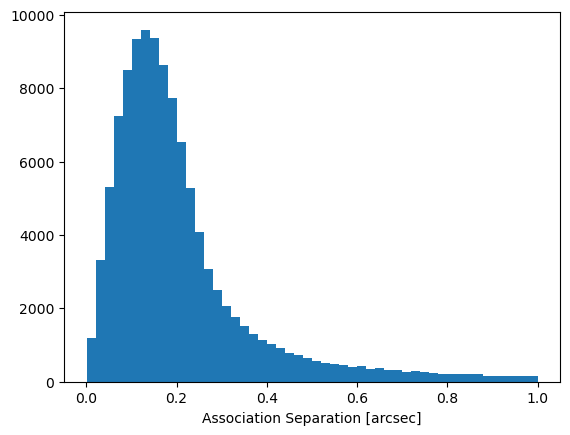

In [10]:
plt.hist(g_tab['association_separation_arcsec'], bins=50)
plt.xlabel('Association Separation [arcsec]')
plt.show()

In [29]:
from astropy.coordinates import SkyCoord
SkyCoord(97.32338747677, 13.552311184820883, unit='deg').to_string('hmsdms')

'06h29m17.61299442s +13d33m08.32026536s'

In [12]:
test = ascii.read('/Users/adamboesky/Research/long_transients/Data/catalog_results/field_results/000513_g.ecsv').copy()
test['dmag'] = np.abs(test['ZTF_gKronMag'] - test['ZTF_gPSFMag'])
test[['ra', 'dec', 'dmag']]

ra,dec,dmag
float64,float64,float64
97.08175280337181,13.558841024788052,nan
97.0487448669643,13.558118691302987,nan
97.39974898203306,13.562550638574045,nan
97.5335982212585,13.564133481484006,nan
97.6024104038957,13.565077439278404,nan
96.82416357927866,13.554107540493181,nan
97.09757402861538,13.558415568921832,nan
97.61685622727617,13.564489659064673,nan
97.2150653490892,13.559343250308224,nan


In [47]:
test_snr_mask = get_snr_from_mag(test['ZTF_gKronMag'], test['ZTF_gKronMagErr'], zp=25) > 3
src = test[np.logical_and(test['ZTF_sepExtractionFlag'] == 1, test_snr_mask)][100]
src[['ra', 'dec', 'dmag']]

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_20026/2294796586.py:5: RuntimeWarning: overflow encountered in power
  flux = 10 ** ((mag - zero_point) / -2.5)
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_20026/2294796586.py:13: RuntimeWarning: invalid value encountered in divide
  return flux / fluxerr


ra,dec,dmag
float64,float64,float64
97.33846748533014,13.552421270332482,0.7648410290872363


In [45]:
from Extracting.Tile import Tile
src_tile = Tile(ra=src['ra'], dec=src['dec'], bands=['g'], data_dir='/Users/adamboesky/Research/long_transients/Data/ztf_data')

Querying metadata from https://irsa.ipac.caltech.edu/ibe/search/ztf/products/deep?WHERE=ra>96.89402303533014+AND+ra<97.78291193533015+AND+dec>13.107976820332482+AND+dec<13.996865720332483+AND+filtercode='zg'
Image already downloaded and saved at /Users/adamboesky/Research/long_transients/Data/ztf_data/ztf_000513_zg_c12_q1_refimg.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


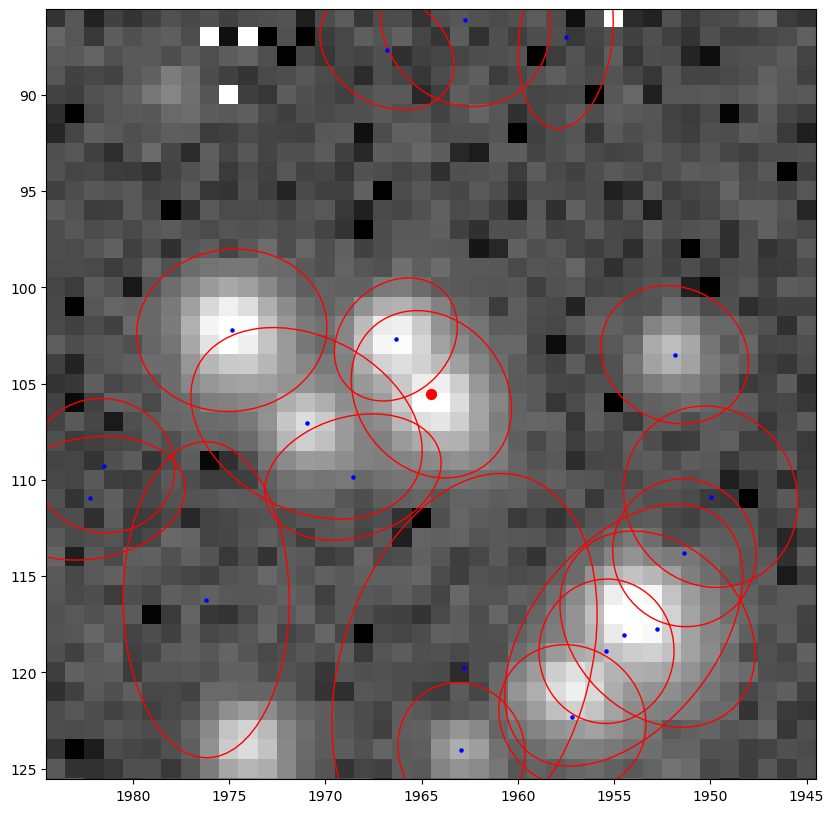

In [48]:
from matplotlib.patches import Ellipse
from astropy.visualization import simple_norm

im_rad = 20
small_test = test[np.logical_and(np.sqrt((test['ZTF_x'] - src['ZTF_x'])**2 + (test['ZTF_y'] - src['ZTF_y'])**2) < im_rad, test_snr_mask)]
image_data = src_tile.ztf_catalogs['g'].sextractors['g'].image_sub.copy()
# image_data = image_data[int(src['ZTF_x']-im_rad):int(src['ZTF_x']+im_rad), int(src['ZTF_y']-im_rad):int(src['ZTF_y']+im_rad)]
# image_data = src_tile.ztf_catalogs['g'].sextractors['g'].get_sources(get_segmap=True)[1]
# image_data = image_data[int(src['ZTF_x']-im_rad):int(src['ZTF_x']+im_rad), int(src['ZTF_y']-im_rad):int(src['ZTF_y']+im_rad)]
# image_data = (image_data != 0).astype(float)
norm = simple_norm(image_data, 'log', percent=99)

fix, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(image_data, cmap='gray', origin='lower', norm=norm)
# ax.imshow(image_data, cmap='gray')
for j in range(len(small_test)):
    e = Ellipse(xy=(small_test['ZTF_x'][j], small_test['ZTF_y'][j]),
                width=6*small_test['ZTF_a'][j],
                height=6*small_test['ZTF_b'][j],
                angle=small_test['ZTF_theta'][j] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)
ax.scatter(small_test['ZTF_x'], small_test['ZTF_y'], s=5, color='blue')
ax.scatter(src['ZTF_x'], src['ZTF_y'], s=50, color='red')
plt.xlim((src['ZTF_x'] - im_rad, src['ZTF_x'] + im_rad))
plt.ylim((src['ZTF_y'] - im_rad, src['ZTF_y'] + im_rad))
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.show()

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_76181/2294796586.py:5: RuntimeWarning: overflow encountered in power
  flux = 10 ** ((mag - zero_point) / -2.5)
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_76181/2294796586.py:13: RuntimeWarning: invalid value encountered in divide
  return flux / fluxerr


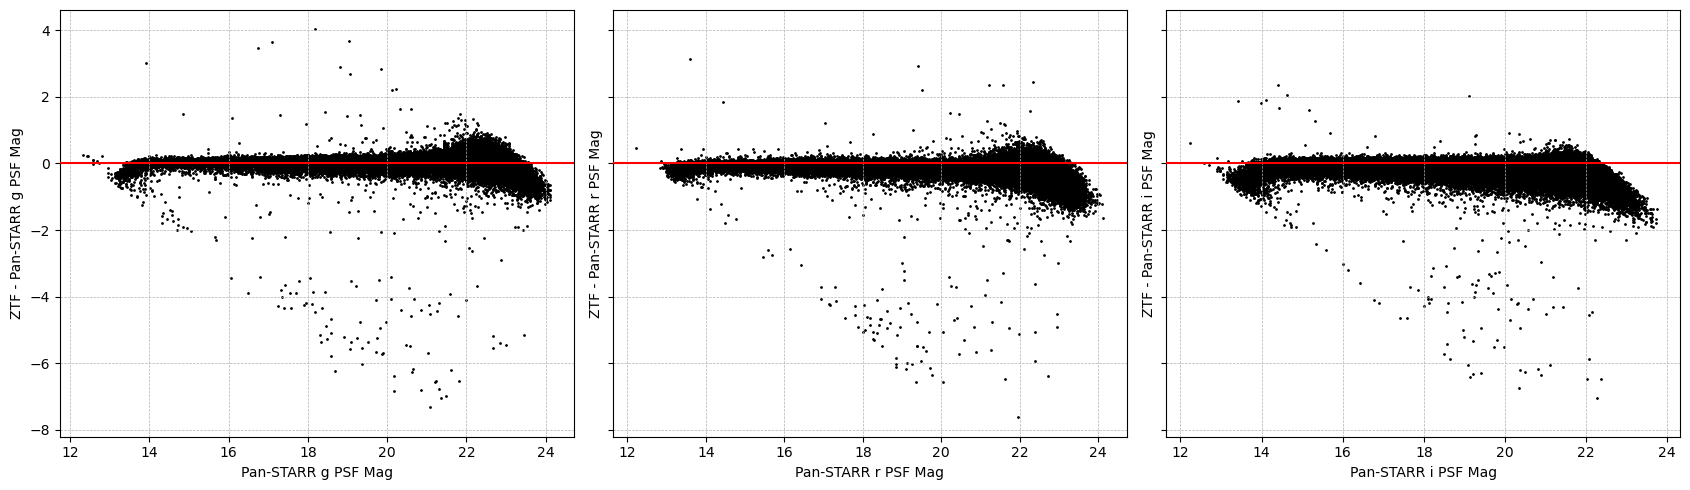

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(17, 5), sharey=True)

for ax, band in zip(axes.flatten(), BANDS):

    # Get the band's table 
    tab = tables[band]

    # Calculate SNRs
    pstarr_snr = get_snr_from_mag(tab[f'PSTARR_{band}PSFMag'], tab[f'PSTARR_{band}PSFMagErr'], zp=25)  #TODO: Check zero points
    ztf_snr = get_snr_from_mag(tab[f'ZTF_{band}PSFMag'], tab[f'ZTF_{band}PSFMagErr'], zp=tab[f'ZTF_{band}_zero_pt_mag'])

    ##### BOTH #####
    # Masks
    snr_mask = (pstarr_snr > 3) & (ztf_snr > 3)
    both_mask = (tab['Catalog'] == 'Both') & (tab[f'PSTARR_{band}PSFMag'] != -999) & (tab[f'ZTF_{band}PSFFlags'] == 0)

    # Plot
    mask = both_mask & snr_mask
    ax.scatter(
        tab[mask][f'PSTARR_{band}PSFMag'],
        tab[mask][f'ZTF_{band}PSFMag'] - tab[mask][f'PSTARR_{band}PSFMag'],
        color='k',
        s=1,
    )

    # Formatting
    ax.axhline(0, color='red', zorder=10)
    ax.grid(lw=0.5, ls='--')
    ax.set_ylabel(f'ZTF - Pan-STARR {band} PSF Mag')
    ax.set_xlabel(f'Pan-STARR {band} PSF Mag')

ylims = np.array([ax.get_ylim() for ax in axes])
for ax in axes:
    ax.set_ylim(np.min(ylims), np.max(ylims))

plt.tight_layout()
plt.show()

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_76181/2294796586.py:5: RuntimeWarning: overflow encountered in power
  flux = 10 ** ((mag - zero_point) / -2.5)
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_76181/2294796586.py:13: RuntimeWarning: invalid value encountered in divide
  return flux / fluxerr


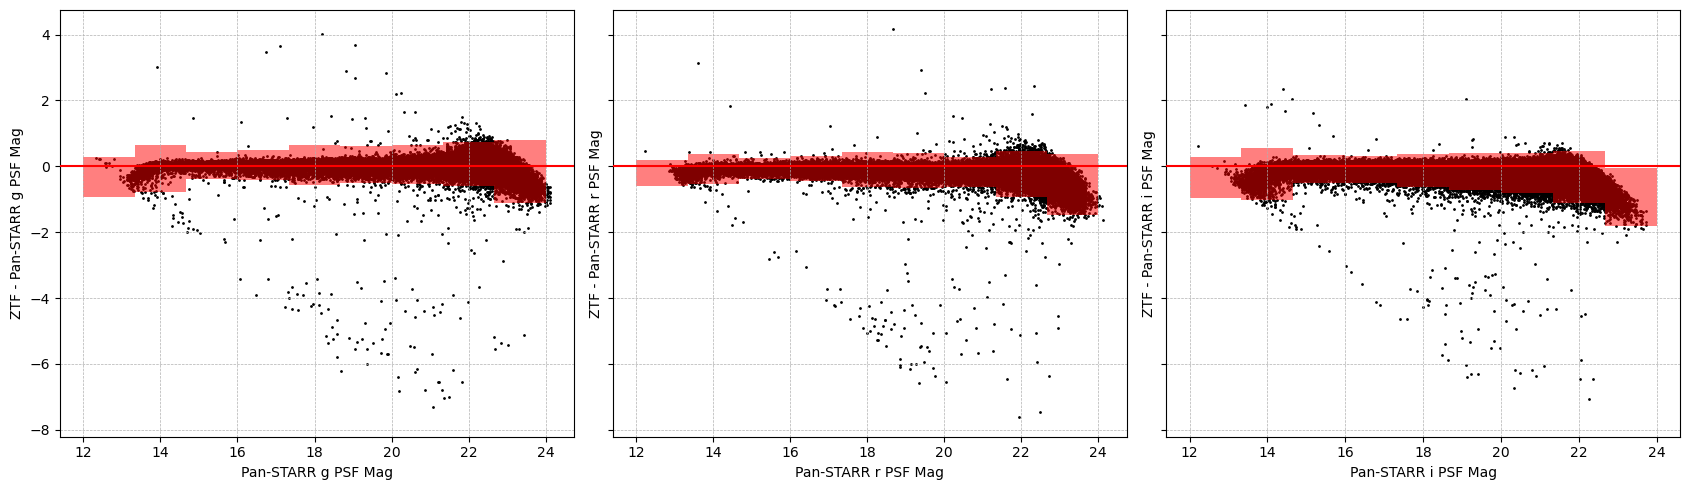

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(17, 5), sharey=True)

for ax, band in zip(axes.flatten(), BANDS):

    # Get the band's table 
    tab = tables[band]

    # Calculate SNRs
    pstarr_snr = get_snr_from_mag(tab[f'PSTARR_{band}PSFMag'], tab[f'PSTARR_{band}PSFMagErr'], zp=25)  #TODO: Check zero points
    ztf_snr = get_snr_from_mag(tab[f'ZTF_{band}PSFMag'], tab[f'ZTF_{band}PSFMagErr'], zp=tab[f'ZTF_{band}_zero_pt_mag'])

    ##### BOTH #####
    # Masks
    snr_mask = (pstarr_snr > 3) & (ztf_snr > 3)
    both_mask = (tab['Catalog'] == 'Both') & (tab[f'PSTARR_{band}PSFMag'] != -999)
    mask = both_mask & snr_mask

    # Get the 3-sigma boundaries on delta mag
    mag_bin_edges = np.linspace(12, 24, num=10)
    bin_means, bin_stds = [], []
    for i in range(len(mag_bin_edges) - 1):
        lower, upper = mag_bin_edges[i], mag_bin_edges[i+1]
        bin_mask = both_mask & snr_mask & (tab[f'PSTARR_{band}PSFMag'] > lower) & (tab[f'PSTARR_{band}PSFMag'] < upper)

        bin_means.append(np.mean(tab[bin_mask][f"ZTF_{band}PSFMag"] - tab[bin_mask][f"PSTARR_{band}PSFMag"]))
        bin_stds.append(np.std(tab[bin_mask][f"ZTF_{band}PSFMag"] - tab[bin_mask][f"PSTARR_{band}PSFMag"]))

    # Plot
    ax.scatter(
        tab[mask][f'PSTARR_{band}PSFMag'],
        tab[mask][f'ZTF_{band}PSFMag'] - tab[mask][f'PSTARR_{band}PSFMag'],
        color='k',
        s=1,
    )

    # Plot the bin mean +- 3sigma with rectangles for each bin
    for lower, upper, mean, std in zip(mag_bin_edges[:-1], mag_bin_edges[1:], bin_means, bin_stds):
        rect = plt.Rectangle(
            (lower, mean - (3 * std)),
            upper - lower,
            6 * std,
            color='red',
            alpha=0.5,
            lw=0,
        )
        ax.add_patch(rect)

    # Formatting
    ax.axhline(0, color='red', zorder=10)
    ax.grid(lw=0.5, ls='--')
    ax.set_ylabel(f'ZTF - Pan-STARR {band} PSF Mag')
    ax.set_xlabel(f'Pan-STARR {band} PSF Mag')

ylims = np.array([ax.get_ylim() for ax in axes])
for ax in axes:
    ax.set_ylim(np.min(ylims), np.max(ylims))

plt.tight_layout()
plt.show()